In [1]:
# Connection to google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import random
#import zipfile
import tensorflow as tf
from keras.models import Model
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Flatten, BatchNormalization, Dropout, Activation
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from sklearn.metrics import classification_report, log_loss, accuracy_score

In [3]:
#source path for training data
source_path='/content/drive/MyDrive/rice_leaf_disease/colab/dataset/image'


In [4]:
Training_DIR = os.path.join(source_path, 'training/original_image')
Validation_DIR = os.path.join(source_path, 'testing/original_image')

In [5]:
# Use the Image Data Generator to import the images from the dataset
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    rotation_range=30,
                                    zoom_range=0.2,
                                    width_shift_range=0.1,
                                    height_shift_range=0.2,
                                    shear_range=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(Training_DIR,
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 2968 images belonging to 4 classes.


In [7]:
test_set = test_datagen.flow_from_directory(Validation_DIR,
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 600 images belonging to 4 classes.


In [8]:
pretrained_model = tf.keras.applications.DenseNet121(input_shape=(256,256,3),
                                                include_top=False,
                                                weights='imagenet')

29084464/29084464 [==============================] - 2s 0us/step


In [9]:
pretrained_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [10]:
# Freeze all layers of the new model
for layer in pretrained_model.layers:
    layer.trainable = False

In [11]:
pretrained_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [12]:
# adding dense layer to train the model
inputs = pretrained_model.input
x = tf.keras.layers.Flatten()(pretrained_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

# create a model object
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [13]:
# training rate used in vgg16 0.001
# tell the model what cost and optimization method to use

from tensorflow.keras.callbacks import ReduceLROnPlateau
#  the learning rate will be reduced by a factor of 0.1 if the validation loss does not improve after 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

from keras.callbacks import EarlyStopping
# Define a callback that stops training when the accuracy stops improving
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, min_delta=0.001, mode='max')

#since learning rate was not defined so default for adam will be used i.e 0.001
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
train = model.fit(training_set,
                validation_data = test_set, 
                epochs = 200, 
                steps_per_epoch = len(training_set),
                validation_steps = len(test_set),
                callbacks=[reduce_lr, early_stopping]
                )


Epoch 1/200
93/93 [==============================] - 1548s 17s/step - loss: 1.1908 - accuracy: 0.7025 - val_loss: 0.8323 - val_accuracy: 0.7633 - lr: 0.0010
Epoch 2/200
93/93 [==============================] - 61s 658ms/step - loss: 0.5328 - accuracy: 0.8036 - val_loss: 0.4393 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 3/200
93/93 [==============================] - 61s 652ms/step - loss: 0.4930 - accuracy: 0.8147 - val_loss: 0.5054 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 4/200
93/93 [==============================] - 63s 675ms/step - loss: 0.4636 - accuracy: 0.8319 - val_loss: 0.3826 - val_accuracy: 0.8483 - lr: 0.0010
Epoch 5/200
93/93 [==============================] - 62s 662ms/step - loss: 0.4472 - accuracy: 0.8389 - val_loss: 0.3810 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 6/200
93/93 [==============================] - 60s 648ms/step - loss: 0.4443 - accuracy: 0.8396 - val_loss: 0.3740 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 7/200
93/93 [==============================] - 60s 6

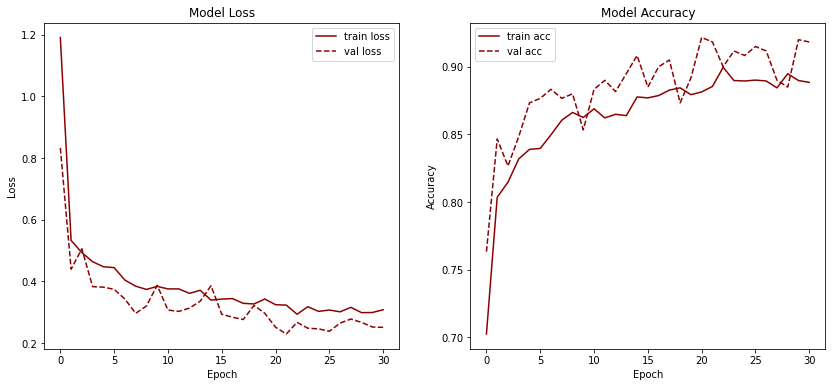

In [15]:
# plot the loss
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
plt.plot(train.history['loss'], label='train loss', color = 'darkred')
plt.plot(train.history['val_loss'], label='val loss',linestyle='--', color = 'darkred')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.show()


plt.subplot(1,2,2)
# plot the accuracy
plt.plot(train.history['accuracy'], label='train acc', color = 'darkred')
plt.plot(train.history['val_accuracy'], label='val acc', linestyle='--', color = 'darkred')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [16]:
print("Final Train Accuracy:", train.history['accuracy'][-1])
print("Final Test Accuracy:", train.history['val_accuracy'][-1])
print("Final Train Loss:", train.history['loss'][-1])
print("Final Test Loss:", train.history['val_loss'][-1])

Final Train Accuracy: 0.888477087020874
Final Test Accuracy: 0.9183333516120911
Final Train Loss: 0.3077033758163452
Final Test Loss: 0.25061726570129395


In [17]:
# save it as a h5 file
tf.keras.models.save_model(model, '/content/drive/MyDrive/rice_leaf_disease/colab/models/densenet121_original_image.h5')